Import Modules

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from tqdm.notebook import tqdm
from PIL import Image
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

Load the Dataset

In [5]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace/'

In [6]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [7]:
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = image_paths, age_labels, gender_labels
data.head()

image  age  gender
0  /kaggle/input/utkface-new/UTKFace/26_0_2_20170...   26       0
1  /kaggle/input/utkface-new/UTKFace/22_1_1_20170...   22       1
2  /kaggle/input/utkface-new/UTKFace/21_1_3_20170...   21       1
3  /kaggle/input/utkface-new/UTKFace/28_0_0_20170...   28       0
4  /kaggle/input/utkface-new/UTKFace/17_1_4_20170...   17       1

In [8]:
gender_dict = {0:'Male', 1:'Female'}

In [9]:
data['gender'].value_counts()

gender
0    12391
1    11317
Name: count, dtype: int64

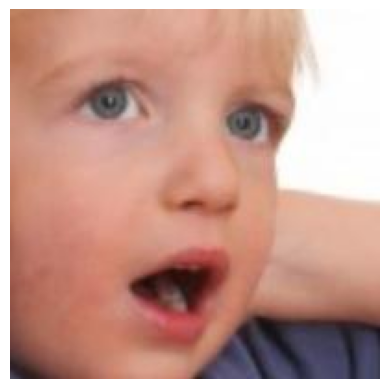

In [10]:
from PIL import Image
img = Image.open(data['image'][22])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

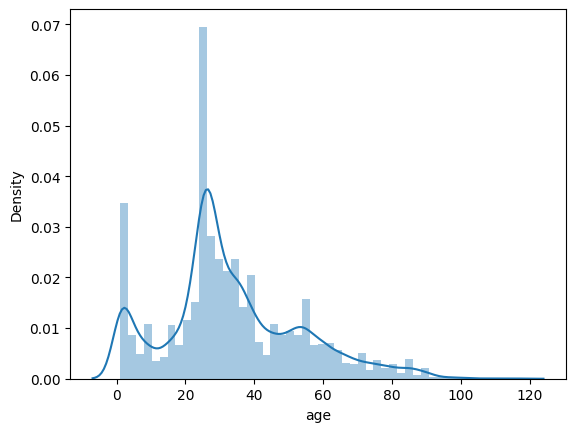

In [11]:
sns.distplot(data['age'])

Exploratory Data Analysis

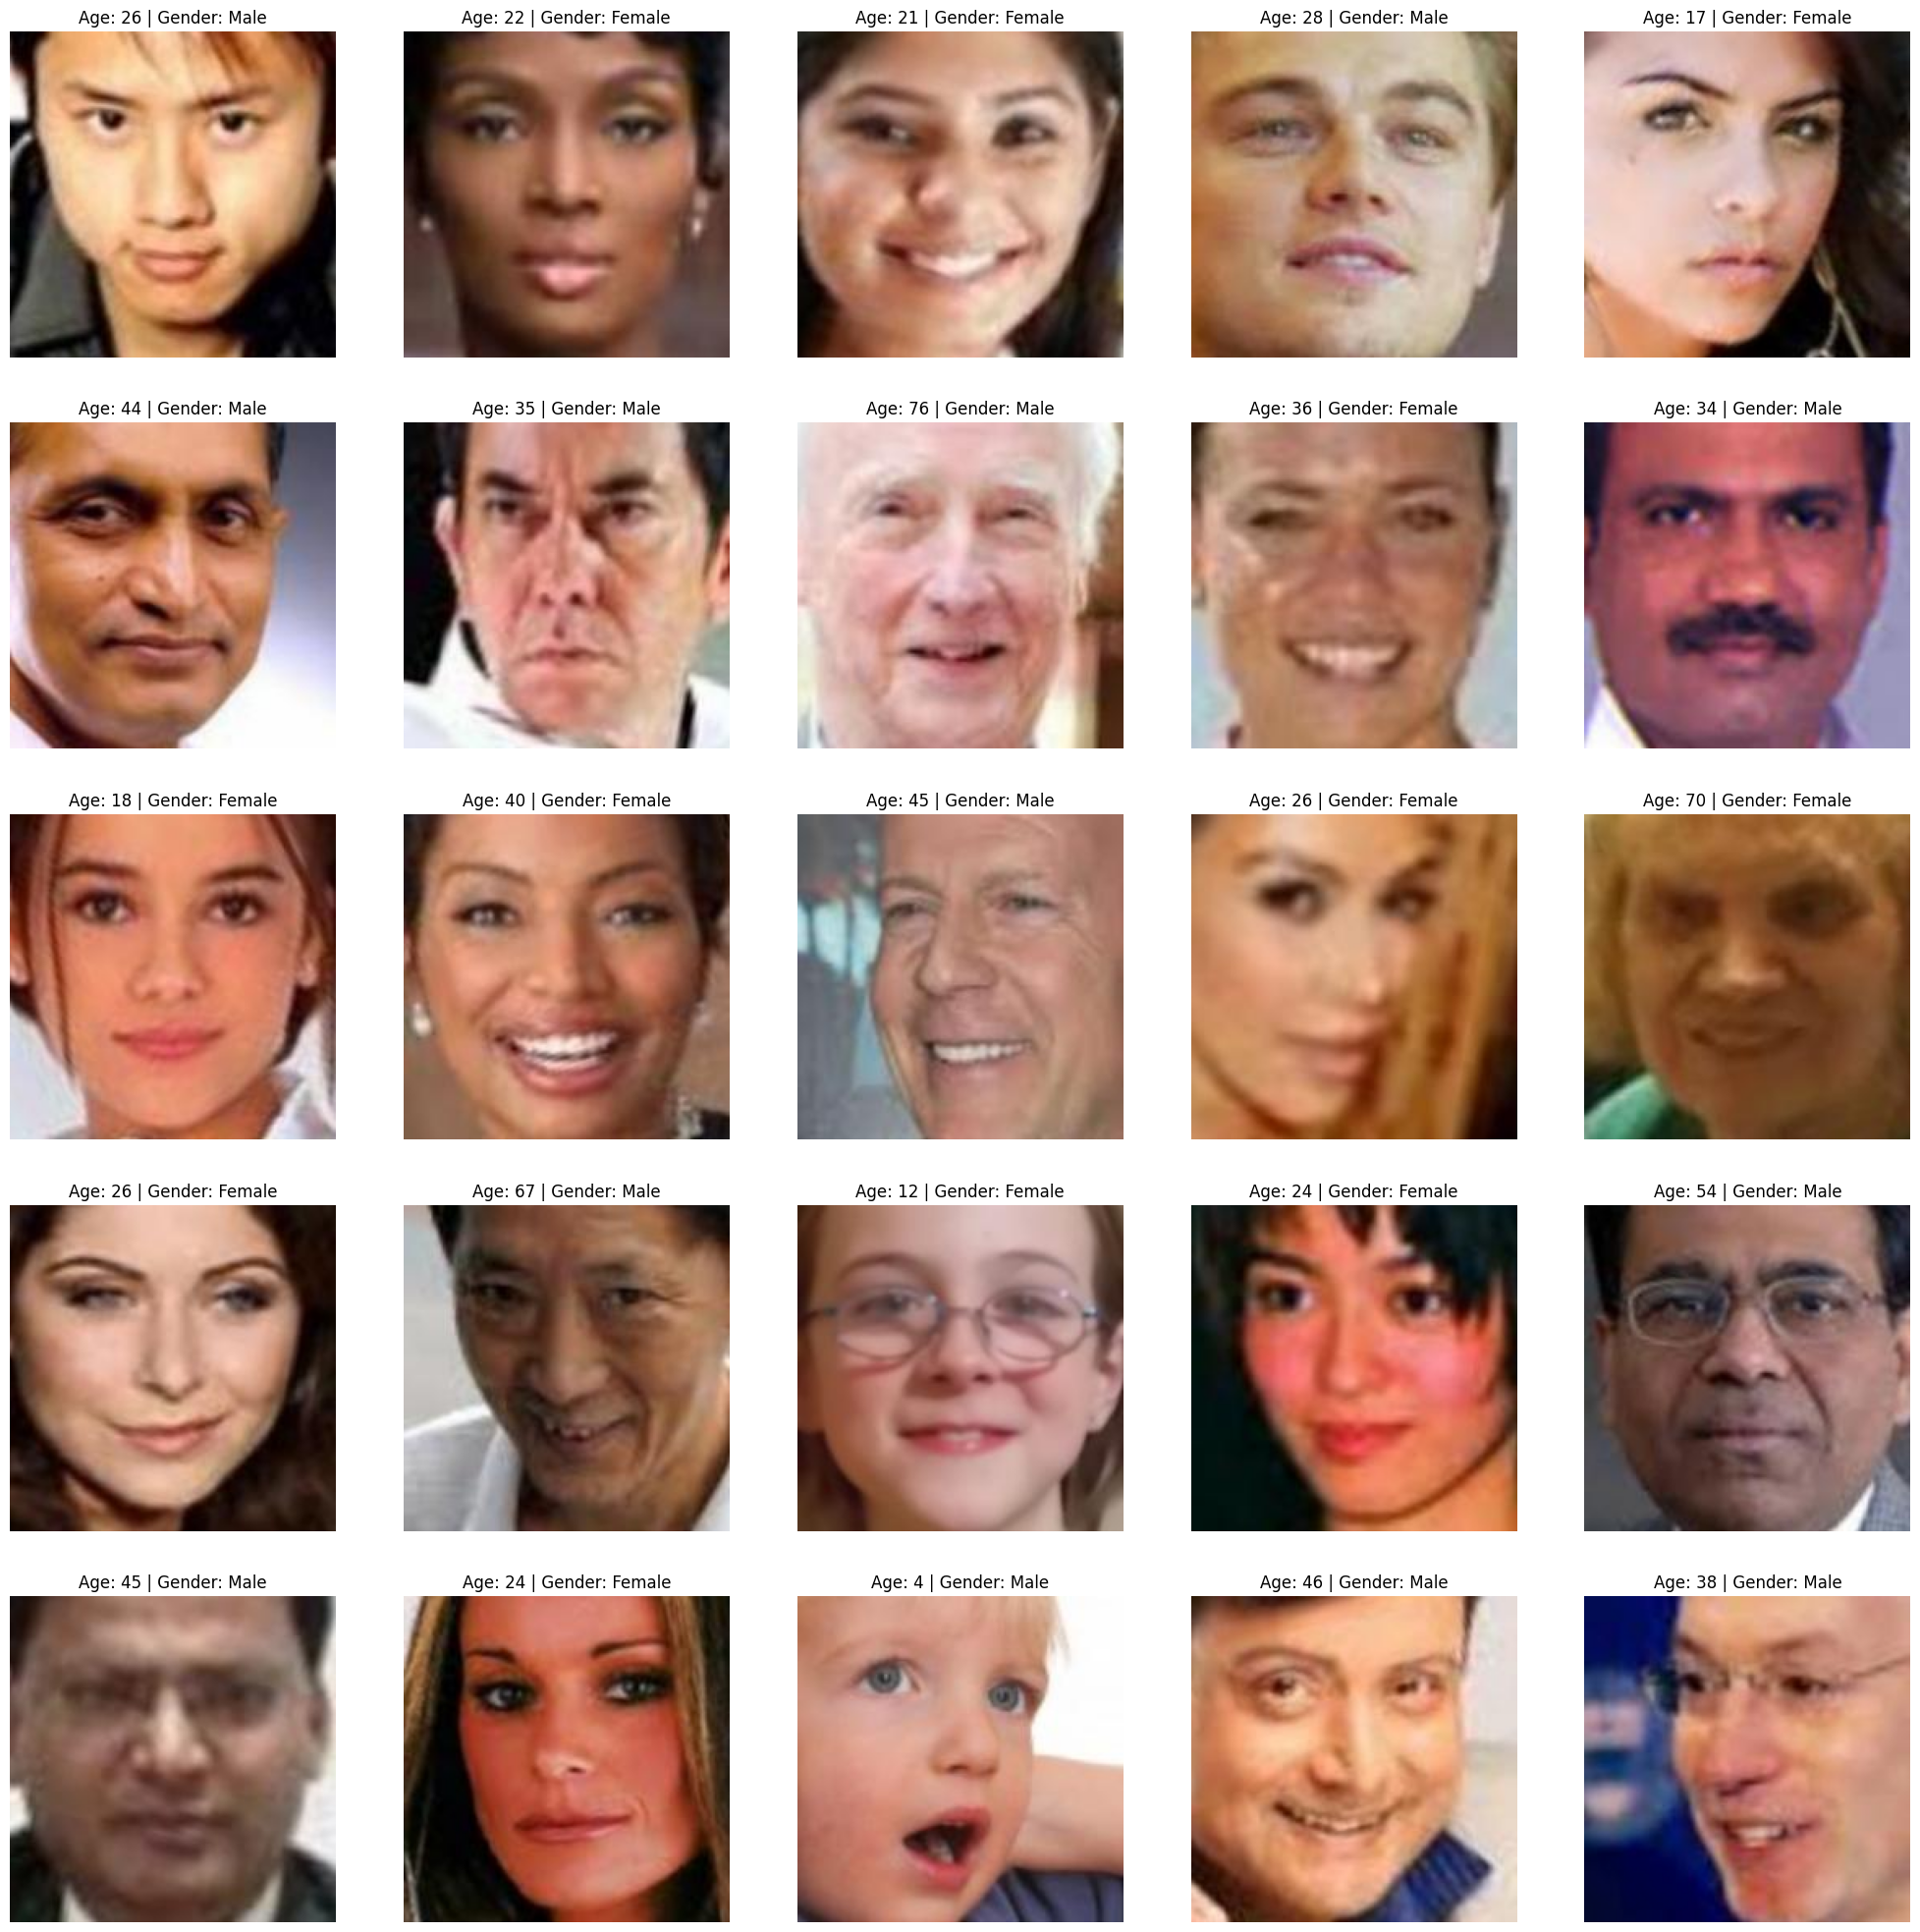

In [12]:
plt.figure(figsize=(25,25))
files = data.iloc[0:25]

for index, files, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    image = plt.imread(files)
    plt.imshow(image)
    plt.title(f'Age: {age} | Gender: {gender_dict[gender]}')
    plt.axis('off')

Feature Extraction

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')
        img = img.resize((128, 128))
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [14]:
X = extract_features(data['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
X = X/255.0

In [17]:
y_gender = np.array(data['gender'])
y_age = np.array(data['age'])

In [18]:
input_shape = (128, 128, 1)

Model Creation

In [19]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3,3), activation = 'relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation = 'relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation = 'relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation = 'relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation = 'relu') (flatten)
dense_2 = Dense(256, activation = 'relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_1)

output_1 = Dense(1, activation = 'sigmoid', name = 'gender_out') (dropout_1)
output_2 = Dense(1, activation = 'relu', name = 'age_out') (dropout_2)

model = Model(inputs = [inputs], outputs = [output_1, output_2])

model.compile(loss = ['binary_crossentropy', 'mae'], optimizer = 'adam', metrics = ['accuracy', 'accuracy'])

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 256) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 9216)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  2,359,552 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,747,906 (10.48 MB)

 Trainable params: 2,747,906 (10.48 MB)

 Non-trainable params: 0 (0.00 B)

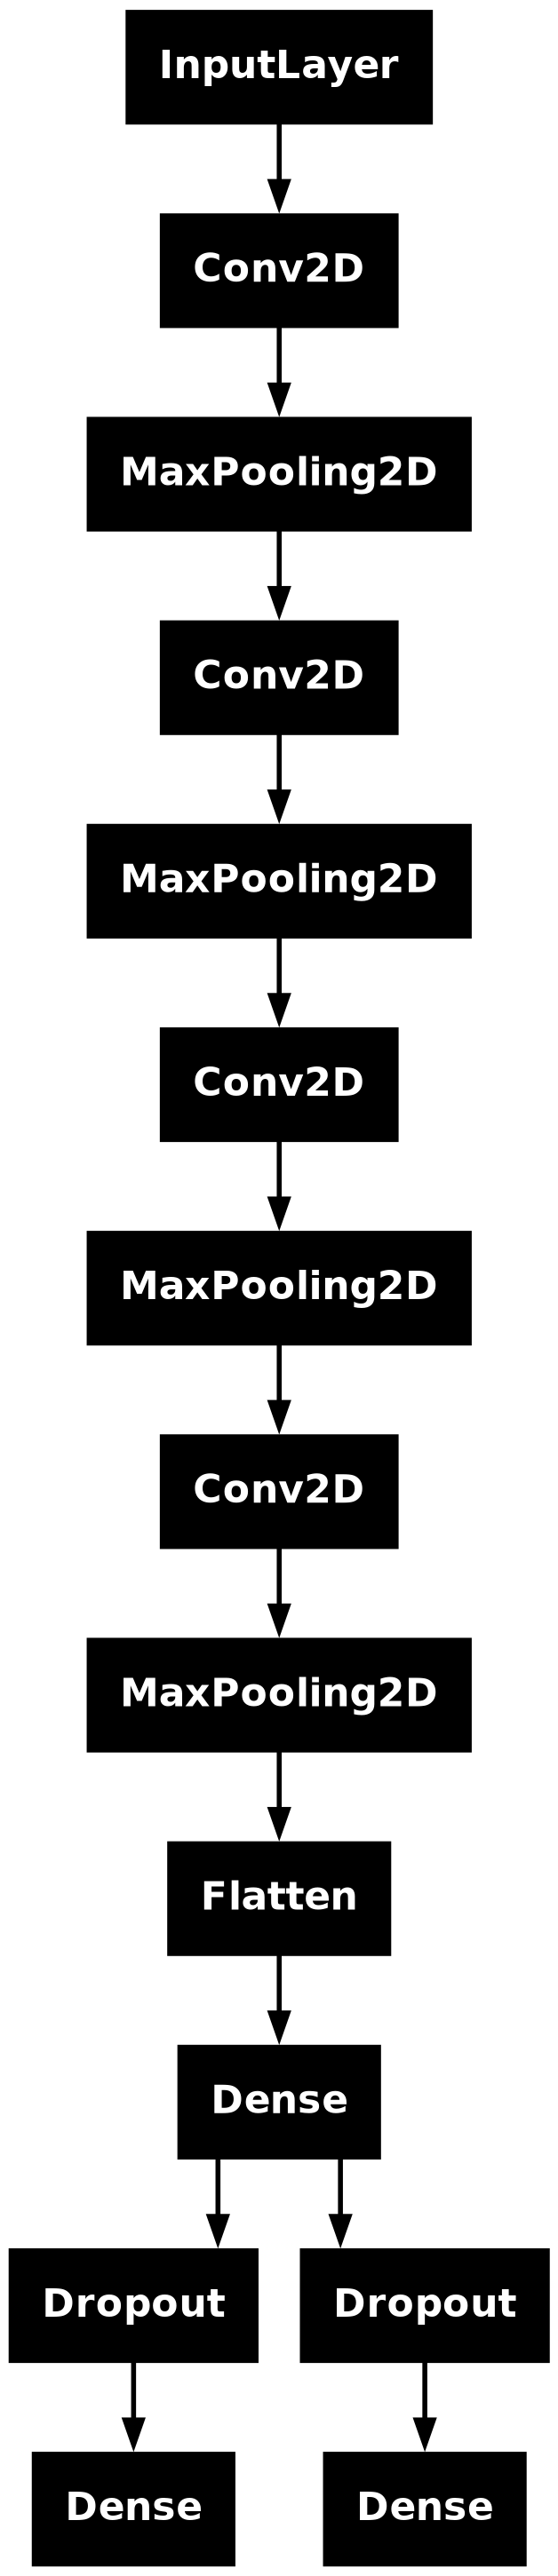

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Train the Model

In [22]:
history=model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15


I0000 00:00:1731681542.761593     514 service.cc:145] XLA service 0x7f31e0006590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731681542.761646     514 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731681542.761649     514 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  7/593 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - age_out_accuracy: 0.0082 - gender_out_accuracy: 0.5595 - loss: 31.3468     

I0000 00:00:1731681549.454306     514 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - age_out_accuracy: 0.0492 - gender_out_accuracy: 0.5469 - loss: 17.6507 - val_age_out_accuracy: 0.0356 - val_gender_out_accuracy: 0.7425 - val_loss: 11.7950
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - age_out_accuracy: 0.0369 - gender_out_accuracy: 0.7367 - loss: 11.9851 - val_age_out_accuracy: 0.0183 - val_gender_out_accuracy: 0.7935 - val_loss: 10.9682
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - age_out_accuracy: 0.0237 - gender_out_accuracy: 0.7830 - loss: 9.8417 - val_age_out_accuracy: 0.0141 - val_gender_out_accuracy: 0.8081 - val_loss: 8.6311
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - age_out_accuracy: 0.0200 - gender_out_accuracy: 0.8134 - loss: 8.7056 - val_age_out_accuracy: 0.0137 - val_gender_out_accuracy: 0.8275 - val_loss: 8.1569
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - age_out_accuracy: 0.0177 - gender_out_accuracy: 0.8354 - loss: 8.2303 - val_age_out_accuracy: 0.0148 - val_gend

Plot Results for Gender

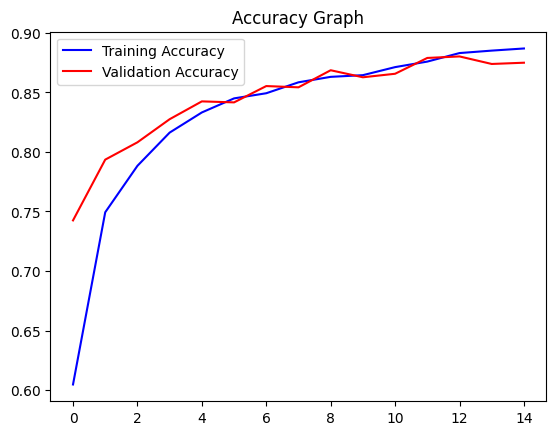

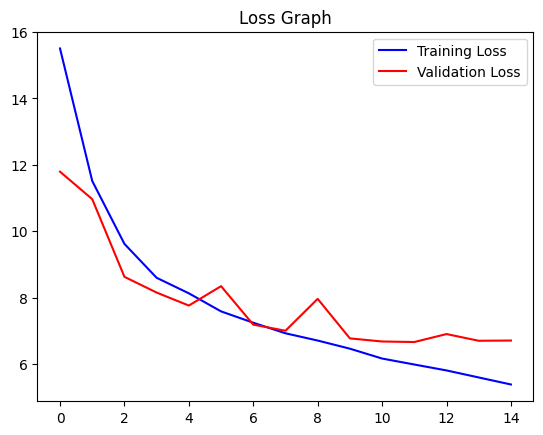

In [23]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Plot Results for Age

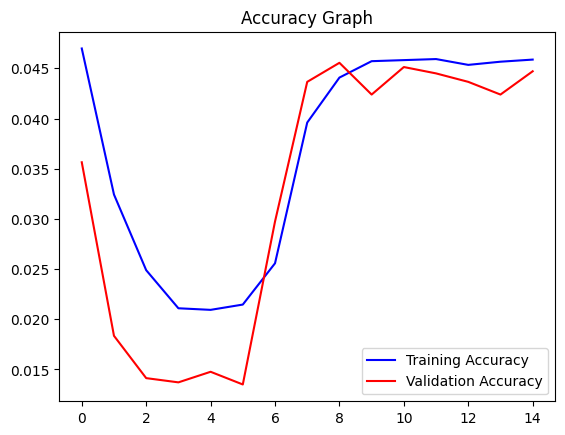

In [24]:
loss = history.history['age_out_accuracy']
val_loss = history.history['val_age_out_accuracy']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

Prediction with Test Data

Original Gender: Female Original Age: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Female Predicted Age: 2


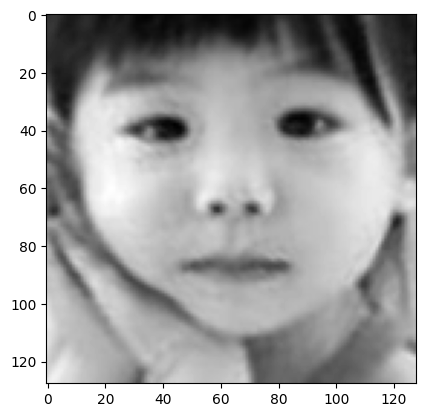

In [27]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#Prediction from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

plt.imshow(X[image_index].reshape(128, 128), cmap = 'gray')

Original Gender: Male Original Age: 45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Gender: Male Predicted Age: 32


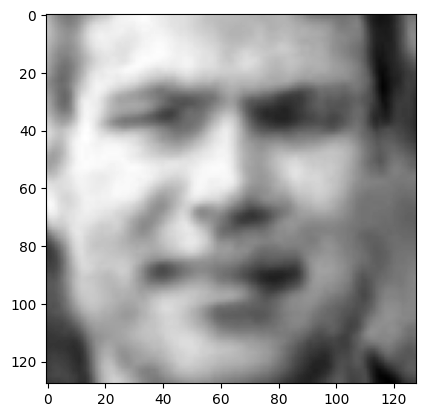

In [28]:
image_index = 2000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#Prediction from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

plt.imshow(X[image_index].reshape(128, 128), cmap = 'gray')

Original Gender: Female Original Age: 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Female Predicted Age: 47


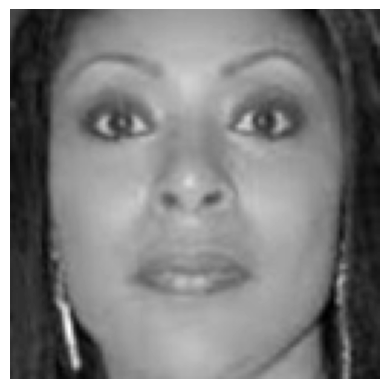

In [30]:
image_index = 52
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#Prediction from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap = 'gray')

Original Gender: Male Original Age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Gender: Male Predicted Age: 30


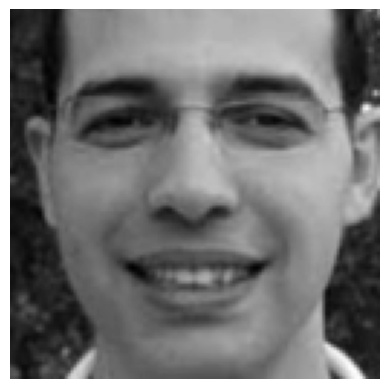

In [31]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#Prediction from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap = 'gray')

Original Gender: Male Original Age: 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 38


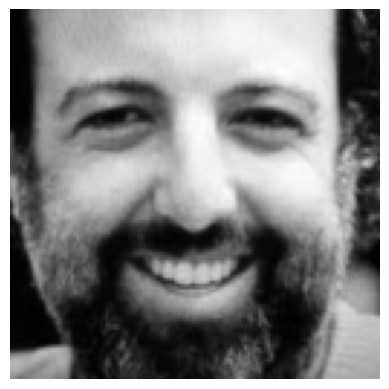

In [32]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

#Prediction from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap = 'gray')